In [424]:
import qutip as qt
import numpy as np
import lmfit as lm
import matplotlib.pyplot as plt
from lmfit import Model

π = np.pi
_ = %precision 3

<div>
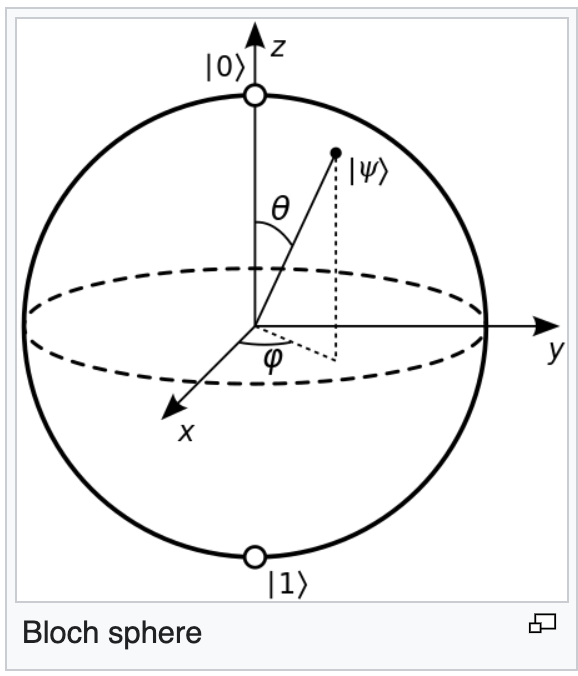
</div>

## Generate Bloch Vectors

In [425]:
def blochvector(theta, phi, p):
    r = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
    bloch_sphere = qt.Bloch(figsize=(3,3))
    bloch_sphere.add_vectors(r)
    if p:
        bloch_sphere.show()
    return r

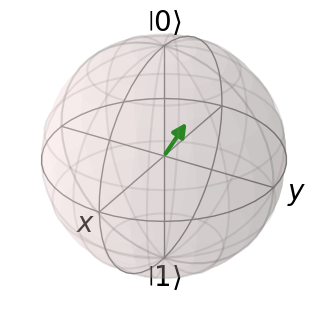

[0.500, 0.500, 0.707]

In [426]:
theta = π/4
phi = π/4
blochvector(theta, phi, True)

## Convert Density Operators to Bloch Vectors

In [427]:
def tobloch(rho):
    a = rho[0,0]
    b = rho[1,0]
    c = rho[0,1]
    d = rho[1,1]
    
    x = 2*np.real(b)
    y = 2*np.imag(b)
    z = 2*a - 1
    
    return [x, y, z]

$|g\rangle=(1,0)^T$, $|e\rangle=(0,1)^T$

In [428]:
g_state = qt.basis(2, 0)
e_state = qt.basis(2, 1)

rho0 = e_state * e_state.dag()
tobloch(rho0)

[0.000, 0.000, (-1+0j)]

## Bloch Vector to Density Operator

In [429]:
theta = π/2
phi = π/4
blochvec = blochvector(theta, phi, False)

In [430]:
def torho(blochvec):
    sx = qt.sigmax()
    sy = qt.sigmay()
    sz = qt.sigmaz()

    x = blochvec[0]
    y = blochvec[1]
    z = blochvec[2]

    rho = 0.5*(qt.qeye(2) + x*sx + y*sy + z*sz)
    return rho

## Simple Check (not exhaustive of errors)

In [431]:
thetas = np.linspace(0, π, 10)
phis = np.linspace(0, 2*π, 10)

results = []
for theta in thetas:
    for phi in phis:
        blochvec = blochvector(theta, phi, False)
        results.append([blochvec, tobloch(torho(blochvec))])     

In [432]:
results

[[[0.000, 0.000, 1.000], [0.000, 0.000, (1+0j)]],
 [[0.000, 0.000, 1.000], [0.000, 0.000, (1+0j)]],
 [[0.000, 0.000, 1.000], [0.000, 0.000, (1+0j)]],
 [[-0.000, 0.000, 1.000], [0.000, 0.000, (1+0j)]],
 [[-0.000, 0.000, 1.000], [0.000, 0.000, (1+0j)]],
 [[-0.000, -0.000, 1.000], [0.000, 0.000, (1+0j)]],
 [[-0.000, -0.000, 1.000], [0.000, 0.000, (1+0j)]],
 [[0.000, -0.000, 1.000], [0.000, 0.000, (1+0j)]],
 [[0.000, -0.000, 1.000], [0.000, 0.000, (1+0j)]],
 [[0.000, -0.000, 1.000], [0.000, 0.000, (1+0j)]],
 [[0.342, 0.000, 0.940], [0.342, 0.000, (0.9396926207859084+0j)]],
 [[0.262, 0.220, 0.940], [0.262, 0.220, (0.9396926207859084+0j)]],
 [[0.059, 0.337, 0.940], [0.059, 0.337, (0.9396926207859084+0j)]],
 [[-0.171, 0.296, 0.940], [-0.171, 0.296, (0.9396926207859084+0j)]],
 [[-0.321, 0.117, 0.940], [-0.321, 0.117, (0.9396926207859084+0j)]],
 [[-0.321, -0.117, 0.940], [-0.321, -0.117, (0.9396926207859084+0j)]],
 [[-0.171, -0.296, 0.940], [-0.171, -0.296, (0.9396926207859084+0j)]],
 [[0.059, 

# Test 1

$\rho_0 = |\psi\rangle \langle\psi|$

$L_1 = \sigma^- = |0\rangle \langle1|$,  $\gamma_1 = \gamma$,  $\gamma_{\alpha\ge2} = 0$,  $H = 0$

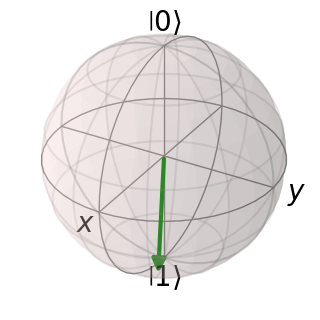

In [433]:
theta = π - π/8
phi = π/4 - π/8
blochvec = blochvector(theta, phi, True)
rho0 = torho(blochvec)

a = qt.destroy(2)
gamma = 0.1
c_ops = [np.sqrt(gamma) * a]

In [434]:
times = np.linspace(0, 100, 1000)
H = qt.Qobj([[0,0], [0,0]])
result = qt.mesolve(H, rho0, times, c_ops)

In [435]:
result.states[-1]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1.000e+00+0.j 1.191e-03-0.j]
 [1.191e-03+0.j 4.366e-05+0.j]]

In [436]:
xs = []
ys = []
zs = []

for state in result.states:
    xs.append(qt.expect(sx, state))
    ys.append(qt.expect(sy, state))
    zs.append(qt.expect(sz, state))

Text(0.5, 1.0, 'Expectation Values of $\\rho_0$ Overtime under $H=0$, $L_1=\\sigma^-$, $\\gamma=0.1$')

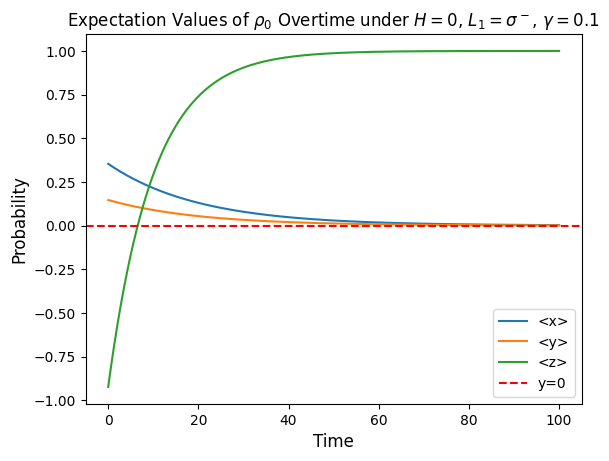

In [437]:
fig, ax = plt.subplots()
plt.plot(times, xs, label='<x>')
plt.plot(times, ys, label='<y>')
plt.plot(times, zs, label='<z>')
_ = ax.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.legend()
plt.xlabel('Time', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title(r'Expectation Values of $\rho_0$ Overtime under $H=0$, $L_1=\sigma^-$, $\gamma=0.1$', fontsize=12)

In [438]:
#exact functional form of amplitude decay of an underdamped harmonic oscillator
def decay1(t, A, gamma):
    return A * np.exp(-0.5*(gamma*t))

model = Model(decay1)
params = model.make_params(A=1, gamma=0.5)
result = model.fit(xs, params, t=times)

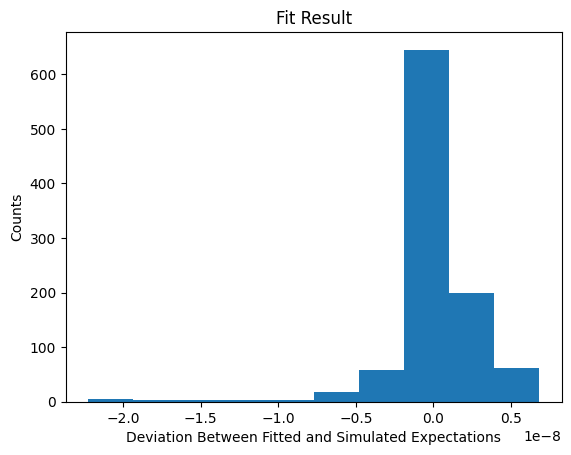

In [439]:
fig = plt.figure()
_ = plt.hist(result.params['A']*np.exp(-0.5*(result.params['gamma']*times)) - xs)
_ = plt.xlabel('Deviation Between Fitted and Simulated Expectations')
_ = plt.ylabel('Counts')
_ = plt.title('Fit Result')

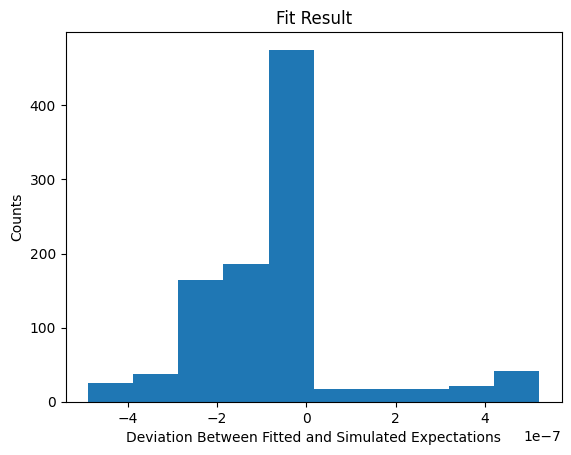

In [440]:
#exact functional form of amplitude decay of an underdamped harmonic oscillator
def decay2(t, A, gamma):
    return 1 + ((A-1)*np.exp(-1*(gamma*t)))

model = Model(decay2)
params = model.make_params(A=1, gamma=0.5)
result = model.fit(zs, params, t=times)

fig = plt.figure()
_ = plt.hist(1+((result.params['A']-1)*np.exp(-1*(result.params['gamma']*times))) - zs)
_ = plt.xlabel('Deviation Between Fitted and Simulated Expectations')
_ = plt.ylabel('Counts')
_ = plt.title('Fit Result')

# Test 2

$\rho_0 = |\psi\rangle \langle\psi|$

$L_1 = \sigma^-_1 \otimes \mathbb{1}_2 = |0\rangle_1 \langle1|_1 \otimes \mathbb{1}_2$,  $\gamma_1 = 0.1$,  $\gamma_{\alpha\ge2} = 0$

$H/\hbar = {\frac{\omega_1}{2} a^\dagger a + \frac{\omega_2}{2} b^\dagger b } + g(a^\dagger b + b^\dagger a).$

In [456]:
psi0 = qt.tensor(g_state, e_state)
rho0 = psi0 * psi0.dag()

a = qt.tensor(qt.destroy(2), qt.qeye(2))
gamma = 0.1
c_ops = [np.sqrt(gamma) * a]

gg_proj = qt.tensor(g_state, g_state).proj()
ge_proj = qt.tensor(g_state, e_state).proj()
eg_proj = qt.tensor(e_state, g_state).proj()
ee_proj = qt.tensor(e_state, e_state).proj()

def hamiltonian(omega_1, omega_2, g):
    t1 = omega_1 / 2 * adag * a
    t2 = omega_2 / 2 * bdag * b
    t3 = g * ((adag * b) + (bdag * a))
    return t1 + t2 + t3

omega = 2*π * 6000 #6 Ghz converted to microsecond timescale
g = π 

h_onres = hamiltonian(omega_1=omega, omega_2=omega, g=g)
times = np.linspace(0, 15, 601)

In [442]:
result = qt.mesolve(h_onres, rho0, times, c_ops)

In [443]:
result.states[0].ptrace(0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

In [444]:
zs = []
for state in result.states:
    zs.append(qt.expect(sz, state.ptrace(0)))

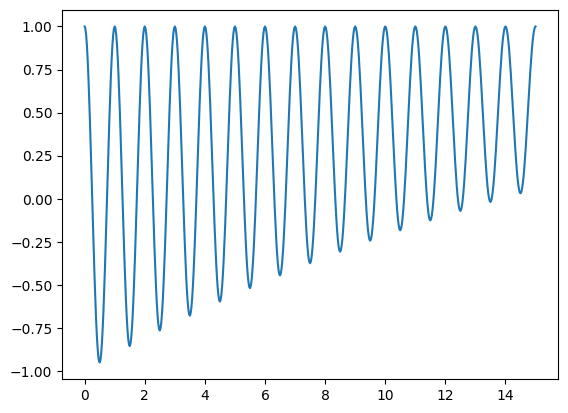

In [445]:
plt.plot(times, zs)

In [467]:
def fn(t, A, gamma, omega, delta):
    return A * np.exp(-1*(gamma*t)) * np.cos(omega*t-delta)

model = Model(fn)
params = model.make_params(A=1, gamma=0.5, omega=omega, delta=3)
result = model.fit(zs, params, t=times)

In [468]:
result

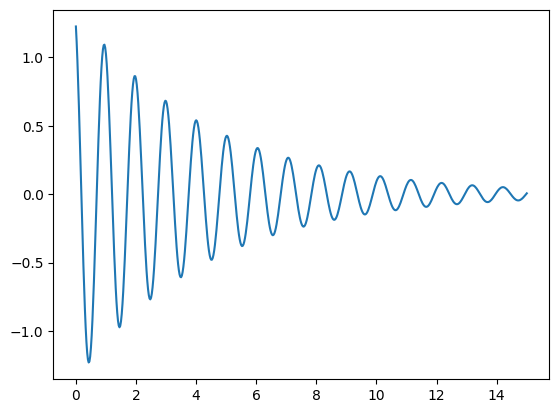

In [469]:
plt.plot(times, 
         (
        result.params['A'].value) * 
         (np.exp(-1*(result.params['gamma'].value*times))) * 
         np.cos((result.params['omega'].value*times)-result.params['delta'].value)
        )